#  Chapter 21 - Natural Language Processing

### Import Packages

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, List, Dict
from collections import defaultdict, Counter
import random
import math
import operator

In [152]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

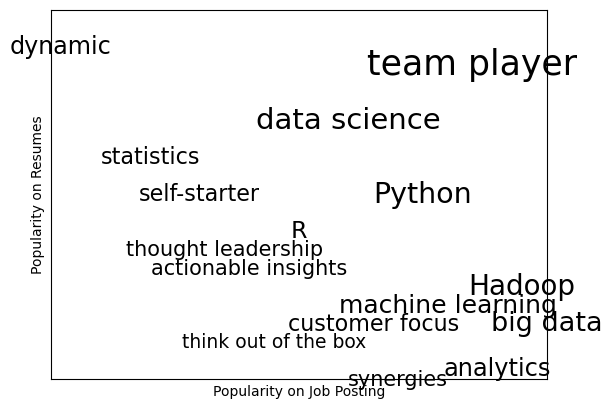

In [153]:
def text_size(total: int) -> float:
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
             ha='center', va='center',
             size=text_size(job_popularity + resume_popularity))
    
plt.xlabel("Popularity on Job Posting")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

#### Unicode Approach

In [154]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

### n-Gram Language Models

In [155]:
import re
from bs4 import BeautifulSoup
import requests

In [156]:
url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

In [157]:
# content = soup.find("div", "article-body")   # find article-body div
# regex = r"[\w']+|[\.]"                       # matches a word or a period

# document = []
# for paragraph in content("p"):
#     words = re.findall(regex, fix_unicode(paragraph.text))
#     document.extend(words)

In [158]:
# transitions = defaultdict(list)
# for prev, current in zip(document, document[1:]):
#     transitions[prev].append(current)

In [159]:
def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

#### Tri-grams transitions

In [160]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

In [161]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

### Grammars

In [162]:
from typing import Dict

In [163]:
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

In [164]:
# Helper Function

def is_terminal(token: str) -> bool:
    return token[0] != "_"

In [165]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

In [166]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

### An Aside: Gibss Sampling

In [167]:
random.random()

0.3912094093228269

Text(0.5, 1.0, 'Various Normal cdfs')

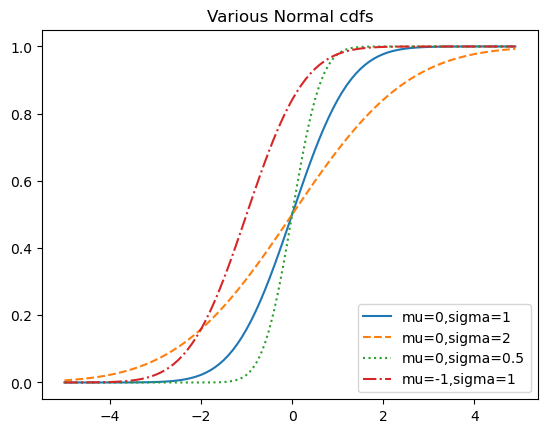

In [168]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
# plt.show()

In [169]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

In [170]:
inverse_normal_cdf(random.random())

-0.33148765563964844

In [171]:
from typing import Tuple

In [172]:
def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [173]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [174]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

### Topic Modeling

In [175]:
from collections import Counter

In [176]:
def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

In [177]:
# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [178]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [179]:
K = 4

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

D = len(documents)

In [180]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

In [181]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [182]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2363.35it/s]


In [183]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [184]:
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

### Word Vectors

In [185]:
Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 32  # 1 * 4 + 2 * 5 + 3 * 6

In [186]:
def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
# assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal

In [187]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

In [188]:
def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50

random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

In [189]:
sentences

['The yellow cat is extremely hard .',
 'The yellow boat was extremely fast .',
 'The black car was quite slow .',
 'The black boat seems quite soft .',
 'The red bed seems extremely hard .',
 'The black bed was  soft .',
 'The black car seems  hard .',
 'The black boat is very slow .',
 'The  cat seems very hard .',
 'The blue car seems extremely slow .',
 'The green car is quite hard .',
 'The red bed was  slow .',
 'The blue boat seems very soft .',
 'The black car seems extremely hard .',
 'The red cat was quite soft .',
 'The green car is very soft .',
 'The yellow bed is quite fast .',
 'The red bed seems  soft .',
 'The black car is  soft .',
 'The yellow cat seems extremely slow .',
 'The blue bed was extremely fast .',
 'The green bed seems extremely slow .',
 'The  car was quite soft .',
 'The yellow bed is quite fast .',
 'The red bed is very fast .',
 'The black bed was very soft .',
 'The red bed seems very fast .',
 'The green bed was quite slow .',
 'The  bed seems  slow

In [190]:
Tensor = list

In [191]:
class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # mapping word -> word_id
        self.i2w: Dict[int, str] = {}  # mapping word_id -> word

        for word in (words or []):     # If words were provided,
            self.add(word)             # add them.

    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # If the word is new to us:
            word_id = len(self.w2i)     # Find the next id.
            self.w2i[word] = word_id    # Add to the word -> word_id map.
            self.i2w[word_id] = word    # Add to the word_id -> word map.

    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """return the word with the given id (or None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

In [192]:
vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3,              "there are 3 words in the vocab"
assert vocab.get_id("b") == 1,       "b should have word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z is not in the vocab"
assert vocab.get_word(2) == "c",     "word_id 2 should be c"
vocab.add("z")
assert vocab.size == 4,              "now there are 4 words in the vocab"
assert vocab.get_id("z") == 3,       "now z should have id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

In [193]:
import json

In [194]:
def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)       # Only need to save w2i

In [195]:
def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it.
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

In [196]:
from typing import Iterable

In [197]:
class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()

In [198]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [199]:
def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

In [200]:
class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # One vector of size embedding_dim for each desired embedding
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)

        # Save last input id
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input id"""
        self.input_id = input_id    # remember for use in backpropagation

        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
        # Zero out the gradient corresponding to the last input.
        # This is way cheaper than creating a new all-zero tensor each time.
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row

        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient

    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

In [201]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructor
        super().__init__(vocab.size, embedding_dim)

        # And hang onto the vocab
        self.vocab = vocab

    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]

        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

In [202]:
import re

In [203]:
tokenized_sentences = [re.findall("[a-z] +| [.]", sentence.lower())
                      for sentence in sentences]

In [204]:
vocab = Vocabulary(word
                   for sentence_words in tokenized_sentences
                   for word in sentence_words)

In [205]:
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]

In [206]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):          # For each word
        for j in [i - 2, i - 1, i + 1, i + 2]:   # take the nearby locations
            if 0 <= j < len(sentence):           # that aren't out of bounds
                nearby_word = sentence[j]        # and get those words.

                # Add an input that's the original word_id
                inputs.append(vocab.get_id(word))

                # Add a target that's the one-hot-encoded nearby word
                targets.append(vocab.one_hot_encode(nearby_word))

In [207]:
class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())


In [208]:
class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

In [209]:
Matrix = List[List[float]]

def shape(A: Matrix) -> Tuple[int, int]:
    """Returns (# of rows of A, # of columns of A)"""
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0   # number of elements in first row
    return num_rows, num_cols

assert shape([[1, 2, 3], [4, 5, 6]]) == (2, 3)  # 2 rows, 3 columns

In [210]:
def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

# assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
# assert shape(random_normal(5, 6, mean=10)) == [5, 6]

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [211]:
random.seed(0)
EMBEDDING_DIM = 5

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [212]:
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
    embedding,
    Linear(input_dim=EMBEDDING_DIM, output_dim= vocab.size)
])

In [213]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

In [214]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

In [215]:
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10


def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]


def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

In [216]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

In [217]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

In [218]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate = 0.01)

In [219]:
for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)
#     print(embedding.closest("black"))
#     print(embedding.closest("slow"))
#     print(embedding.closest("car"))

0 1805.8216036629462
1 1696.0377464796256
2 1665.4694410677487
3 1650.33659480036
4 1640.8730567622276
5 1633.9687393254903
6 1628.3164034826502
7 1623.2632788915982
8 1618.4531329673632
9 1613.6927032416168
10 1608.8987353219386
11 1604.0762230383507
12 1599.3029594804784
13 1594.705239364156
14 1590.4200279706265
15 1586.5535284004925
16 1583.1552371133937
17 1580.218203072224
18 1577.697824132371
19 1575.5334922331679
20 1573.6636538246896
21 1572.0333311963393
22 1570.5966228984935
23 1569.316601685625
24 1568.16411271388
25 1567.1162741282208
26 1566.1550643857804
27 1565.266145821367
28 1564.4379507595727
29 1563.6610007766296
30 1562.9274118863964
31 1562.2305391487048
32 1561.5647221409436
33 1560.9251020823508
34 1560.307489656273
35 1559.7082689828446
36 1559.124327787398
37 1558.5530069061385
38 1557.9920642363024
39 1557.4396493959891
40 1556.8942859702197
41 1556.3548584894957
42 1555.8206013823271
43 1555.291087201552
44 1554.7662115622977
45 1554.246172537382
46 1553.731

In [220]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
         for w1 in vocab.w2i
         for w2 in vocab.w2i
         if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

[(0.9900249515779737, 'k ', 'n '), (0.8763762293665865, 'd ', 't '), (0.7891870870076828, 't ', 'w '), (0.7433018636322485, 'd ', 'r '), (0.5053329099209759, 'r ', 't ')]


#### Last Path

In [221]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

In [223]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

In [225]:
# components = pca(embedding, embeddings, 2)
# transformed = transform(embedding.embeddings, components)

In [226]:
# fig, ax = plt.subplots()
# ax.scatter(*zip(*transformed), marker='.', colon='w')

In [227]:
# for word, idx in vocab.w2i.items():
#     ax.annotate(word, transformed[idx])
    
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

# plt.show()

### Recurrent Neural Networks

In [228]:
def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [230]:
class SimpleRnn(Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.w = random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = random_tensor(hidden_dim)

        self.reset_hidden_state()

    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]

    def forward(self, input: Tensor) -> Tensor:
        self.input = input              # Save both input and previous
        self.prev_hidden = self.hidden  # hidden state to use in backprop.

        a = [(dot(self.w[h], input) +           # weights @ input
              dot(self.u[h], self.hidden) +     # weights @ hidden
              self.b[h])                        # bias
             for h in range(self.hidden_dim)]

        self.hidden = tensor_apply(tanh, a)  # Apply tanh activation
        return self.hidden                   # and return the result.

    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b has the same gradient as a
        self.b_grad = a_grad

        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]